# Clustering Final Notebook

In [1]:
# Performing the many imports required to do the various analyses of this notebook:
import pandas as pd
import numpy as np
import os
from env import host, user, password
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import env
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.impute import SimpleImputer
import scipy
import sklearn.linear_model
import sklearn.preprocessing
import warnings
warnings.filterwarnings("ignore")
import wrangle
import viz_explore
import brian_feature_engineering
import brian_model
import cluster_model
import scipy.stats as stats
from sklearn.cluster import KMeans

from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import sklearn.linear_model
import sklearn.preprocessing
import warnings

# ZILLOW PROJECT
## Predicting the logerror of single family homes in the Los Angeles area

## Brian Clements and Christian Freeman
### 1/10/2022

## Project Description

This Jupyter Notebook and presentation explore the Zillow dataset from the Codeup database. The data used relates to 2017 real estate transactions relating to single family homes in three California counties, and different aspects of the properties. An important aspect of the Zillow business model is to be able to publish accurate home values; I intend to build a machine learning model that makes predictions about the tax value of the homes in question.

I will use Residual Mean Square Error as my metric for evaluation; many models will be built using different features and hyperparameters to find the model of best fit.  One of the final deliverables will be the RMSE value resulting from my best model, contrasted with the baseline RMSE.

Additionally, a Jupyter Notebook with my main findings and conclusions will be a key deliverable; many .py files will exist as a back-up to the main Notebook (think "under-the-hood" coding that will facilitate the presentation).

## Project Goals

The ultimate goal of this project is to build a model that predicts the logerror of the homes in question with a higher accuracy than the baseline we have chosen--the purpose being to be able to produce better, more accurate home price predictions than Zillow's competitors. 

## Executive Summary

Zillow needs to publish the most accurate home valuations possible to remain the relevant, reliable service that it is known to be.  This study has employed a machine learning algorithm to predict the logerror of our current home value estimates, with an eye to improving future estimates.  This study included clustering techniques, which were ultimately part of the model that improved the logerror estimate by over 1.5% above baseline.

In [2]:
# THE WRANGLE FUNCTION PERFORMS THE FOLLOWING, IN BROAD STROKES:
# 1. Get the data via SQL query
# 2. Clean and prep the data
# 3. Encode the appropriate columns (only ['county'] for now)
# 4. Split the data: train, validate, test and X_ vs y_ splits as well
# 5. Scale the data (all train, validate and test, and all X_ and y_ splits are scaled)

df, train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test, \
train_scaled, X_train_scaled, y_train_scaled, validate_scaled, X_validate_scaled, \
y_validate_scaled, test_scaled, X_test_scaled, y_test_scaled \
= wrangle.wrangle_zillow()

# Exploration: univariate

- The main standouts here were the number of rooms, which has a considerable right skew (also, all homes that had previously had "zero" rooms were imputed to the mean), as well as the many outliers in certain attributes, which have been left even after applying a "remove_outliers" function in the wrangle module.

### Exploration question 1:

### Is there a time period that has a higher or lower log error?

<AxesSubplot:xlabel='age_bin', ylabel='logerror'>

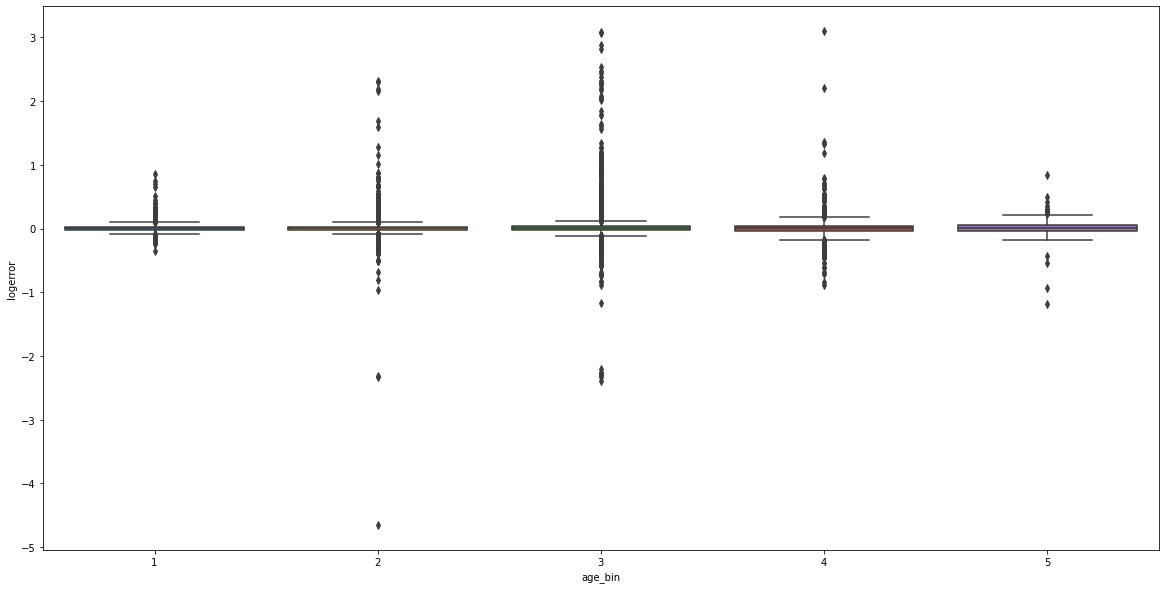

In [7]:
# Here, I draw up a cell with the boxplot of logerror for each age bin
plt.figure(figsize=(20,10))
sns.boxplot(x='age_bin', y='logerror', data= train)

- As can be seen again, there are more outliers in the middle. Unfortunately, this could also be due to more data being available in those age bins

### Exploration answer 1:
- There is a small amount of difference in the logerror for middle-aged homes.  Possibly helpful for modeliing
- Statistical testing showed we can proceed with the understanding that the average logerror is different depending on the age of the home
- The different counties also display different variances in their logerror by age.

### Exploration question 2:

- What about a relationship between tax_value and logerror?

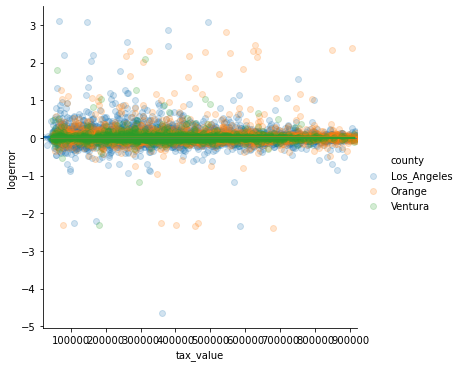

In [8]:
# A seaborn lmplot to visualize the trendlines of the logerror by tax_value/county
sns.lmplot(x='tax_value', y='logerror', data=train, scatter_kws={'alpha':.2},hue='county')

- They look like perfectly flat trend lines

### Exploration answer 2:

- Based on the above and other visual exploration, there are not any clear impressions

### Exploration question 3:
- Does the condition of the home have an impact on the logerror?

<AxesSubplot:xlabel='condition', ylabel='logerror'>

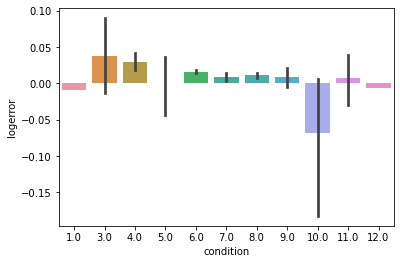

In [9]:
# A seaborn barplot to vizualize the logerror of the different house 'conditions'
sns.barplot(x=train.condition,y=train.logerror, data=train)

- The logerror is off by more on the houses with a condition of 10 and 3

### A T-Test is in order to show this:

First, a Levene test to check on variances:

- Hypotheses:
    - #H0: Variances are equal
    - #Ha: Variances are not equal

In [11]:
# Levene test for equal variances...they aren't equal
stats.levene(train.condition==1,train.condition==3,train.condition==4,train.condition==5,
            train.condition==6,train.condition==7,train.condition==8,train.condition==9,
            train.condition==10, train.condition==11,train.condition==12)

LeveneResult(statistic=6602.5022161121415, pvalue=0.0)

Set Hypothesis (for the t-test)
- 𝐻0 : Population means of logerror (by condition) are equal
- 𝐻𝑎 : Population means of logerror (by condition) are not all equal

In [12]:
# the anova test:
f, p = stats.f_oneway(train.condition==1,train.condition==3,train.condition==4,train.condition==5,
            train.condition==6,train.condition==7,train.condition==8,train.condition==9,
            train.condition==10, train.condition==11,train.condition==12)
f,p

(17326.94526429442, 0.0)

In [13]:
# Setting our alpha and returning a statemtent on the validity of the ANOVA test by comparing alpha to the resulting p-value

alpha = 0.05
if p < alpha:
    print("We reject H_O")
else:
    print("We fail to reject $H_{0}$")

We reject H_O


### Exploration answer 3:
- The condition of a home does in fact bear on its logerror

### Exploration question 4:
- How does logerror differ from one county to the next?

<AxesSubplot:xlabel='county', ylabel='logerror'>

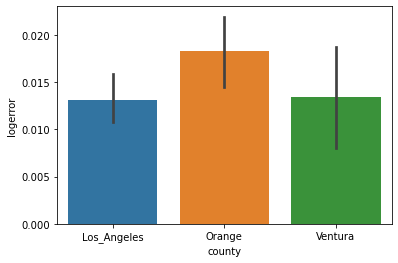

In [14]:
# Seaborn barplot of the logerrors; a boxplot was not visually helpful
sns.barplot(x=train.county, y=train.logerror)

### Running an Kruskal-wallace to check on this

H_0: Average logerror of the three counties is the same


H_a: The logerror is different according to county

- It was shown above that the logerror by county has different variances, so

In [15]:
f,p = scipy.stats.kruskal(train.logerror[train.county == 'Los_Angeles'],\
                          train.logerror[train.county == 'Orange'],\
                          train.logerror[train.county == 'Ventura'],nan_policy='propagate')
f,p

(4.081862375625654, 0.12990768608468994)

In [16]:
# Setting our alpha and returning a statemtent on the validity of the ANOVA test by comparing alpha to the resulting p-value

alpha = 0.05
if p < alpha:
    print("We reject H_O")
else:
    print("We fail to reject $H_{0}$")

We fail to reject $H_{0}$


- The kruskal-wallace statistical test did not show that there is a significant difference in the logerrors of the different counties

### Exploration answer 4:
- There is not enough evidence to understand the logerror differs significantly from one county to another.

### Exploration question 5:
- Does having a half bathroom make a difference for logerror?

<AxesSubplot:xlabel='has_half_bath', ylabel='logerror'>

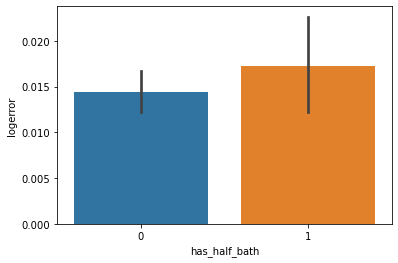

In [17]:
# A barplot showing the difference in logerror for has_half_bath or not.
sns.barplot(x=train.has_half_bath,y=train.logerror)

- There is some difference, but not a lot...proceeding to stats testing via one sided, independent t test

First: assumptions:

- Normally distributed...basically yes and many observations
- Independence: check
- Variances...are almost equal actually


Set Hypothesis

H_0
: Mean of logerror of has_half_bath = Mean of logerror of no_half_bath

H_a
: Mean of logerror of has_half_bath != Mean of logerror of no_half_bath

In [18]:
# defining samples first:
has_half_bath_sample = train[train.has_half_bath == 1].logerror
no_half_bath_sample = train[train.has_half_bath==0].logerror
# this cell runs an independent t-test to compare the means:
t, p = stats.ttest_ind(has_half_bath_sample, no_half_bath_sample, equal_var=False)

t, p

(1.0449975638488767, 0.29607360629596075)

- p is NOT less than alpha (0.05), and therefore the Null Hypothesis cannot be rejected

### Exploration answer 5:
- So, having a half bathroom does not affect logerror.  Not directly for sure

## Exploration Summary:
- Of the five questions answered, my statistical tests and/or visuals rebuffed a full 3 of them as significant for logerror.
- Age and condition are two attributes that may be useful in modelling

# CLUSTERING

### We are clustering on the following attributes:
- sq_ft, price_per_sq_ft, tax_rate

### Conducting some elementary exploration of the target variables for the deal_or_not cluster

In [19]:
# define independent variables for k-means

deal_cluster_df = X_train_scaled[['sq_ft', 'price_per_sq_ft', 'tax_rate']]

- The deal_cluster_df is already scaled
- All the attributes are also normally distributed

### Exploring the cluster attributes:
- Not a lot to be gleaned here

### We ran a find_kmeans function to determine the optimal value for k, which is defined in the folowing cell:

In [23]:
# list of variables we will cluster on. 
cluster_vars = ['sq_ft', 'price_per_sq_ft', 'tax_rate']
cluster_name = 'good_deal_or_not_?'
k_range = range(2,20)

In [24]:
# The following is a function to generaate an elbow chart to help determine the 
# number of clusters to use
# cluster_model.find_k(X_train_scaled, cluster_vars, k_range)

### 5 looks like a good value for k

In [25]:
# Assigning k
k = 5

In [26]:
from sklearn.cluster import KMeans
# sklearn implementation of KMeans

#define the thing
kmeans_deal_cluster_df = KMeans(n_clusters=5, random_state = 123, verbose = 0)

# fit the thing
kmeans_deal_cluster_df.fit(deal_cluster_df)

# Use (predict using) the thing 
kmeans_deal_cluster_df.predict(deal_cluster_df)

array([0, 4, 0, ..., 1, 3, 4], dtype=int32)

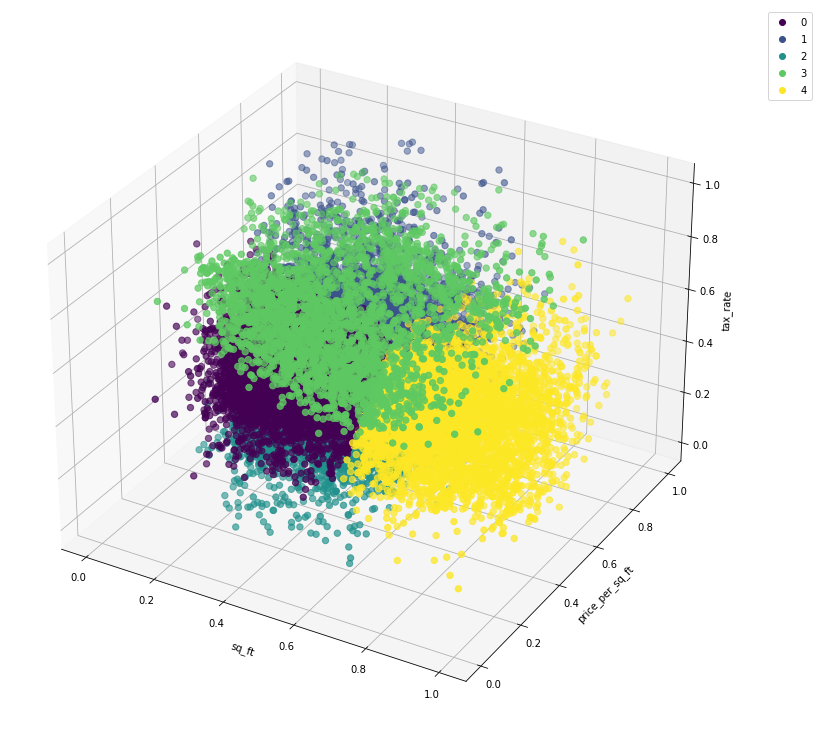

In [27]:
# Code to create a three-3 graph of our clusters

import re, seaborn as sns
import numpy as np
# from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

# The following command will make the graphic interactive
# but it creates problems for subsequent graphics and should be commented out 
# until it's being used

# %matplotlib notebook

# assigning the graphing data
x = deal_cluster_df.sq_ft
y = deal_cluster_df.price_per_sq_ft
z = deal_cluster_df.tax_rate
# axes instance
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)
fig.add_axes(ax)
# get colormap from seaborn
# cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())
t = kmeans_deal_cluster_df.predict(deal_cluster_df)
# plot
# the x,y,z labels might need to be specific...
sc = ax.scatter(x, y, z, s=40, c=t, marker='o')#, cmap=t, alpha=1)
ax.set_xlabel('sq_ft')
ax.set_ylabel('price_per_sq_ft')
ax.set_zlabel('tax_rate')
# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
# plt.savefig("scatter_hue", bbox_inches='tight')

In [28]:
# make a new column names cluster in train, deal_cluster_df and X_scaled dataframes

X_train_scaled['deal_cluster'] = kmeans_deal_cluster_df.predict(deal_cluster_df)
train['deal_cluster'] = kmeans_deal_cluster_df.predict(deal_cluster_df)
deal_cluster_df['deal_cluster'] = kmeans_deal_cluster_df.predict(deal_cluster_df)

In [29]:
# Code to give names to the different deal_clusters:
train['deal_cluster'] = np.where(train.deal_cluster == 0,'large_homes',np.where(train.deal_cluster == 1,'small_to_med_cheaper'\
            ,np.where(train.deal_cluster == 2, 'small_cheap_lowtax',np.where(train.deal_cluster == 3,'small_expensive'\
            ,'small_cheap_midtax'))))

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

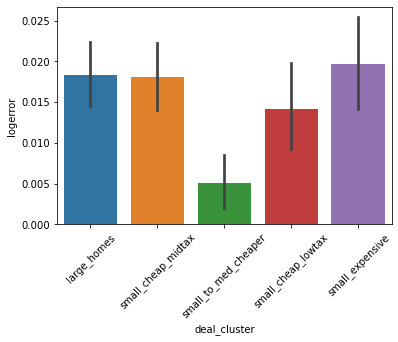

In [30]:
# A seaborn barplot to quickly check logerror by cluster
sns.barplot(x='deal_cluster',y='logerror',data=train)
plt.xticks(rotation=45)
plt.tight_layout

- As can be seen, the small_to_med_cheaper cluster has relatively low logerror

<AxesSubplot:xlabel='county', ylabel='logerror'>

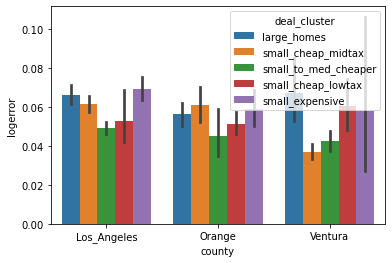

In [31]:
# Checking the logerror of the clusters by county
sns.barplot(x='county',y=df['logerror'].abs(),data=train,hue='deal_cluster')

- The small_cheap_midtax cluster has a lower logerror in Ventura county. Maybe evidence to use different modeling on that county?

### ANOVA testing also established that the logerror of the different clusters is clearly different

#  MODELING

### Scaling
-We have done modeling on the scaled datasets (both X_train and y_train, etc.)

### Baseline
- We will use MEAN as the baseline

### Features
- We will define kbest and rfe features below
- All the X_train_scaled, X_validate_scaled, etc. are scaled from X_train, etc.¶
- All of the X_train_kbest, X_train_rfe, etc are derived from the scaled datasets

In [32]:
# This cell runs my function in feature_engineering.py that selects for the top 'k' number 
# of features
f_feature = brian_feature_engineering.select_kbest(X_train_scaled,y_train_scaled, 5)
f_feature

['bedrooms', 'condition', 'rooms', 'tax_amount', 'price_per_sq_ft']

In [33]:
# Likewise, here we are using a function from the feature_engineering.py file to select for the best RFE features

rfe_feature = brian_feature_engineering.select_rfe(X_train_scaled,y_train_scaled, 5)
rfe_feature

['condition',
 'lot_size',
 'structure_value',
 'sq_ft_per_bathroom',
 'price_per_sq_ft']

## First, we are going to run modeling on just the deal_clusters and have a look at the results

### The next cell establishes baseline as a starting point:

In [34]:
# A function to build 'logerror_pred_mean' on the y_scaled partitions 
# and return the baseline rmse for train and validate:
y_train_scaled, y_validate_scaled, y_test_scaled, rmse_train_cluster, \
rmse_validate_cluster =  brian_model.create_baseline_cluster_model(y_train_scaled, y_validate_scaled, y_test_scaled)
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train_cluster, 5), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate_cluster, 5))

RMSE using Mean
Train/In-Sample:  0.01897 
Validate/Out-of-Sample:  0.01899


In [35]:
# Here, I create a DataFrame to insert the evaluation metrics of the different models; this datafram will be 
# taken in by the modeling function below and expanded on.
metric_df_cluster = pd.DataFrame(data=[
            {
                'model': 'mean_baseline', 
                'RMSE_train': rmse_train_cluster,
                'RMSE_validate': rmse_validate_cluster
                }
            ])
metric_df_cluster

,model,RMSE_train,RMSE_validate
0,mean_baseline,0.018968,0.018994


In [36]:
# defining a small subset dataframe just for the clustering features to be used:
deal_cluster_df_train = X_train_scaled[['sq_ft', 'price_per_sq_ft', 'tax_rate']]
deal_cluster_df_validate = X_validate_scaled[['sq_ft', 'price_per_sq_ft', 'tax_rate']]
deal_cluster_df_test = X_test_scaled[['sq_ft', 'price_per_sq_ft', 'tax_rate']]

In [37]:
# sklearn implementation of KMeans

#define the thing
kmeans_deal_cluster_df = KMeans(n_clusters=5, random_state = 123, verbose = 0)

# fit the thing
kmeans_deal_cluster_df.fit(deal_cluster_df_train)

# Use (predict using) the thing 
kmeans_deal_cluster_df.predict(deal_cluster_df_train)

array([0, 4, 0, ..., 1, 3, 4], dtype=int32)

- Adding a cluster column to each pertinent df

In [39]:
# Adding a "deal_cluster" column to each dataset
X_train_scaled['deal_cluster'] = kmeans_deal_cluster_df.predict(deal_cluster_df_train)
X_train_scaled['deal_cluster'] = np.where(X_train_scaled.deal_cluster == 0,'large_homes',np.where(\
                                X_train_scaled.deal_cluster == 1,'small_to_med_cheaper',\
                                np.where(X_train_scaled.deal_cluster == 2, 'small_cheap_lowtax',\
                                np.where(X_train_scaled.deal_cluster == 3,'small_expensive','small_cheap_midtax'))))


In [40]:
X_validate_scaled['deal_cluster'] = kmeans_deal_cluster_df.predict(deal_cluster_df_validate)
X_validate_scaled['deal_cluster'] = np.where(X_validate_scaled.deal_cluster == 0,'large_homes',np.where(\
                                X_validate_scaled.deal_cluster == 1,'small_to_med_cheaper',\
                                np.where(X_validate_scaled.deal_cluster == 2, 'small_cheap_lowtax',\
                                np.where(X_validate_scaled.deal_cluster == 3,'small_expensive','small_cheap_midtax'))))



In [41]:
X_test_scaled['deal_cluster'] = kmeans_deal_cluster_df.predict(deal_cluster_df_test)
X_test_scaled['deal_cluster'] = np.where(X_test_scaled.deal_cluster == 0,'large_homes',np.where(\
                                X_test_scaled.deal_cluster == 1,'small_to_med_cheaper',\
                                np.where(X_test_scaled.deal_cluster == 2, 'small_cheap_lowtax',\
                                np.where(X_test_scaled.deal_cluster == 3,'small_expensive','small_cheap_midtax'))))




- Encoding the clusters onto the respective dfs

In [42]:
# Running a modeling function to encode our clusters onto the X_ dataframes
X_train_scaled = cluster_model.encode_clusters(X_train_scaled,['deal_cluster'])
X_validate_scaled = cluster_model.encode_clusters(X_validate_scaled,['deal_cluster'])
X_test_scaled = cluster_model.encode_clusters(X_test_scaled,['deal_cluster'])

In [43]:
# Defining the false "kbest" and "rfe" features in order to run the model on the clusters alone
kbest_vars = ['deal_cluster_large_homes',
       'deal_cluster_small_cheap_lowtax', 'deal_cluster_small_cheap_midtax',
       'deal_cluster_small_expensive', 'deal_cluster_small_to_med_cheaper']
rfe_vars = ['deal_cluster_large_homes',
       'deal_cluster_small_cheap_lowtax', 'deal_cluster_small_cheap_midtax',
       'deal_cluster_small_expensive', 'deal_cluster_small_to_med_cheaper']

X_train_kbest, X_validate_kbest, X_test_kbest, X_train_rfe, X_validate_rfe, X_test_rfe = \
brian_model.create_data_for_models_including_clusters(X_train_scaled, X_validate_scaled, X_test_scaled,\
kbest_vars, rfe_vars)

In [46]:
# Creating an evaluation dataframe to see how the different models 
# performed using ONLY the clusters
metric_df_cluster = brian_model.run_all_models_on_all_data(X_train_kbest, \
                y_train_scaled, X_validate_kbest, y_validate_scaled, X_train_rfe, \
                    X_validate_rfe, X_test_kbest, X_test_rfe, metric_df_cluster)

In [47]:
metric_df_cluster

,model,RMSE_train,RMSE_validate
0,mean_baseline,0.018968,0.018994
1,OLS Regressor KBEST,0.018955,0.018994
2,OLS Regressor RFE,0.018955,0.018994
3,Lasso_alpha1_KBEST,0.018968,0.018994
4,Lasso_alpha1_RFE,0.018968,0.018994
5,glm_compound_kbest,0.018955,0.018994
6,glm_compound_rfe,0.018955,0.018994
7,quadratic_kbest,0.018955,0.018995
8,quadratic_rfe,0.018955,0.018995


- Note that the kbest and rfe features are identical in this code--for expediency, I have not (yet) changed the code for running clusters only, and therefore the results between "kbest" features and "rfe" features are identical (they're the same features). I future iteration of the project will address this.

- We also ran a linear regression model on a cluster made up of sq_ft, tax_rate, and longitude; this model came back with unimproved evaluation results, and therefore we proceeded on other features and clusters.

## Final model:

- First, we start modeling fresh, including building a brand new evaluation metric dataframe with the baseline evaluation

In [50]:
# Here, I create a DataFrame to insert the evaluation metrics of the different models; this datafram will be 
# taken in by the modeling function below and expanded on.
y_train_scaled, y_validate_scaled, y_test_scaled, rmse_train, \
rmse_validate =  brian_model.create_baseline_cluster_model(y_train_scaled, \
                        y_validate_scaled, y_test_scaled)

In [51]:
# Building the beginning evaluation df with baseline only
final_metric_df = pd.DataFrame(data=[
            {
                'model': 'mean_baseline', 
                'RMSE_train': rmse_train,
                'RMSE_validate': rmse_validate
                }
            ])
final_metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,0.018968,0.018994


- Next, we re-run the feature engineering to see if any cluster gets included:

In [52]:
# This cell runs my function in feature_engineering.py that selects for the top 'k' number 
# of features
final_kbest_features = brian_feature_engineering.select_kbest(X_train_scaled,y_train_scaled.drop(columns=['logerror_pred_mean', 'logerror_pred_lm_kbest',
       'logerror_pred_lm_rfe', 'logerror_pred_lars_kbest',
       'logerror_pred_lars_rfe', 'logerror_pred_glm_kbest',
       'logerror_pred_glm_rfe', 'logerror_pred_lm2_kbest',
       'logerror_pred_lm2_rfe']), 5)
final_kbest_features

['bedrooms',
 'condition',
 'rooms',
 'price_per_sq_ft',
 'deal_cluster_small_to_med_cheaper']

- Happily, the kbest feature selector grabbed one of our clusters as the fifth most important predictor

In [53]:
# Likewise, for rfe features
final_rfe_features = brian_feature_engineering.select_rfe(X_train_scaled,y_train_scaled.drop(columns=['logerror_pred_mean', 'logerror_pred_lm_kbest',
       'logerror_pred_lm_rfe', 'logerror_pred_lars_kbest',
       'logerror_pred_lars_rfe', 'logerror_pred_glm_kbest',
       'logerror_pred_glm_rfe', 'logerror_pred_lm2_kbest',
       'logerror_pred_lm2_rfe']), 5)
final_rfe_features

['lot_size', 'structure_value', 'tax_value', 'tax_amount', 'price_per_sq_ft']

In [54]:
# Function to create the final dataframes for the model out of the features selected above
final_X_train_kbest, \
final_X_validate_kbest, \
final_X_test_kbest, \
final_X_train_rfe, \
final_X_validate_rfe, \
final_X_test_rfe = \
brian_model.create_data_for_models_including_clusters(X_train_scaled, X_validate_scaled, X_test_scaled,\
final_kbest_features, final_rfe_features)

In [55]:
# Function to run all models on all the above-defined dataframes
final_metric_df = brian_model.run_all_models_on_all_data(final_X_train_kbest, y_train_scaled, final_X_validate_kbest, \
            y_validate_scaled, final_X_train_rfe, final_X_validate_rfe, final_X_test_kbest, \
            final_X_test_rfe, final_metric_df)

In [56]:
final_metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,0.018968,0.018994
1,OLS Regressor KBEST,0.018948,0.018992
2,OLS Regressor RFE,0.018947,0.018989
3,Lasso_alpha1_KBEST,0.018968,0.018994
4,Lasso_alpha1_RFE,0.018968,0.018994
5,glm_compound_kbest,0.018952,0.018993
6,glm_compound_rfe,0.018957,0.018990
7,quadratic_kbest,0.018929,0.019013
8,quadratic_rfe,0.018942,0.018988


### Takeaway: running the models on the clusters only yields a slightly better-than-baseline result, but barely. And the kbest features above (which do actually include one of the clusters) yielded the best results when run on the glm_compound_kbest model (without significant difference to the validate results--the quadratic model run on kbest did return better results on train, but worse on validate, and we are therefore rejecting it).

## Finally: run the model on the test data

In [57]:
# Tweedie on KBEST features:

# as seen in curriculum, the power ought to be set per distribution type
# power = 0 is same as OLS

glm = TweedieRegressor(power=1.4, alpha=0)


# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(final_X_train_kbest, y_train_scaled.logerror)

# predict test
y_test_scaled['logerror_pred_glm_kbest'] = glm.predict(final_X_test_kbest)

# evaluate: rmse
rmse_test = mean_squared_error(y_test_scaled.logerror, y_test_scaled.logerror_pred_glm_kbest) ** (1/2)

# And a statement on the RMSE of the glm model run on test
print("RMSE for Polynomial Model, degrees=2\nTest/Out of Sample: ", rmse_test)

RMSE for Polynomial Model, degrees=2
Test/Out of Sample:  0.018678065852669144


In [58]:
# This is a simple calculation of the improvement over baseline:
(0.018968 - 0.018677) / 0.018968

0.015341628005061135

## That's a 1.5% improvement over baseline

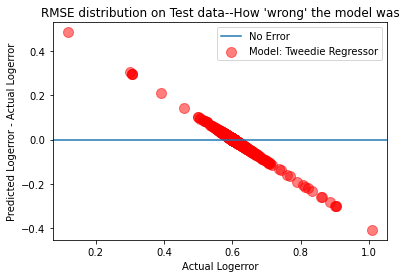

In [59]:
# A matplotlib scatterplot showing the residual error between predicted RMSE and actual tax value

plt.axhline(label="No Error")
plt.scatter(y_test_scaled.logerror, y_test_scaled.logerror_pred_glm_kbest - y_test_scaled.logerror,\
            alpha=.5, color="red", s=100, label="Model: Tweedie Regressor")
plt.legend()
plt.xlabel("Actual Logerror")
plt.ylabel("Predicted Logerror - Actual Logerror")
plt.title("RMSE distribution on Test data--How 'wrong' the model was")
plt.show()

# CONCLUSIONS

## Summary:

At the beginning of my study, I took a few high-level type questions to get a handle on the problem, and refined them slowly with the time that was available:
   
- Is there a time period that has a higher or lower log error?  

- What about a relationship between tax_value and logerror? (also: are these related targets?)

- Does the condition of the home have an impact on the logerror?

- Does (or...how does?) logerror differ by county?

- Does my whole theory about half bathrooms bear out?
    
Most of these initial questions were disproved through exploration and statistical testing, but  there were a couple of gems, and the "condition" of a home was in fact one of the final attributes to make it into the "winning" model.

Our model, which has room for improvement, was capable of predicting the logerror of homes with a 1.5 percent improvement over baseline on the test data, and with similar margins for the train and validate data. We expect it to perform as well on unseen data as well.

## Recommendations

Building models that separate the counties might see some benefit, seeing as there area some different ways that the features work on logerror in different counties.

Explore locations/city ids--we are of the belief that this attribute and related ones (latitue and longitude, for example), may yield some insight.

## Next steps

The following is a brief list of items that we'd like to add to the model:

- A cluster relating to other aspects of a home's value (structure, land, etc)
- Also a cluster related to physical aspects of a home (beds and baths, for instance)
- Continue exploring other features' relationship to logerror, with an eye to mathmatical relationships (our early exploration mistakenly went down a dead end or two because of a failure to switch gears from the target variable of the previous project that this one builds off of)